## Importing libraries and dataset (text file)

In [ ]:
# pip install --user -U nltk
# pip install wordcloud

In [1]:
# Importing the relevant libraries
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
import warnings
# warnings.filterwarnings('ignore')

In [2]:
path_to_local_file = "merged_stories.txt"
with open(path_to_local_file, "r", encoding="utf-8") as file:
    text_data = file.read()
text = text_data

## Observing our dataset

In [3]:
# Printing the first few lines
print(text[:1000])

In olden times when wishing still helped one, there lived a king
whose daughters were all beautiful, but the youngest was so beautiful
that the sun itself, which has seen so much, was astonished whenever
it shone in her face.  Close by the king's castle lay a great dark
forest, and under an old lime-tree in the forest was a well, and when
the day was very warm, the king's child went out into the forest and
sat down by the side of the cool fountain, and when she was bored she
took a golden ball, and threw it up on high and caught it, and this
ball was her favorite plaything.

Now it so happened that on one occasion the princess's golden ball
did not fall into the little hand which she was holding up for it,
but on to the ground beyond, and rolled straight into the water.  The
king's daughter followed it with her eyes, but it vanished, and the
well was deep, so deep that the bottom could not be seen.  At this
she began to cry, and cried louder and louder, and could not be
comforted.  And

In [4]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 898504 characters


In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

62 unique characters


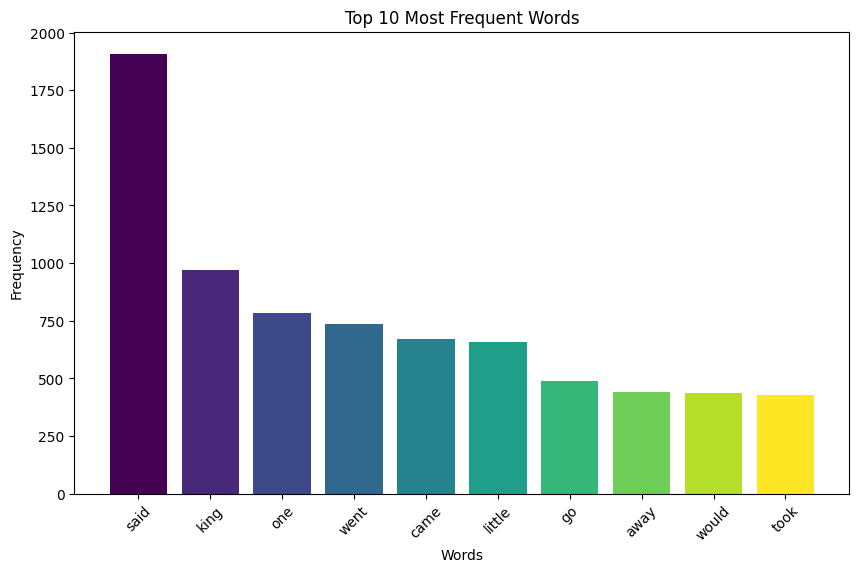

In [6]:
# Taken
# Using the stopwords dataset of nltk library

# Preprocessing the text to extract words
words = re.findall(r'\b\w+\b', text)
stop_words = set(stopwords.words('english'))

# Removing stop words
filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
word_counts = Counter(filtered_words) # Calculating word frequencies

# Get the top 10 most common words and their counts
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)

# Colors for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(words)))

# Plot the top 10 words with custom colors
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color=colors)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

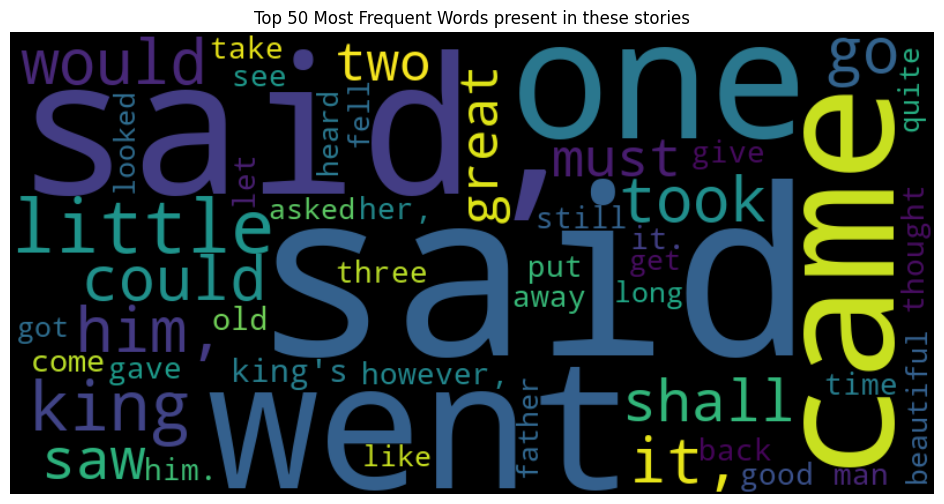

In [7]:
# Download the stopwords dataset from NLTK

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Calculate word frequencies
words = text.split()
word_frequencies = Counter(words)

# Exclude stopwords
word_frequencies = {word: freq for word, freq in word_frequencies.items() if word.lower() not in stop_words}

# Get the top 50 words
top_words = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:50])

# Generate a word cloud from the top 50 words
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_words)

# Display the word cloud using matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Frequent Words present in these stories')
plt.show()

## Understanding how this model will process the text

In [9]:
# How our text will be split
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [10]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [11]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[37, 38, 39, 40, 41, 42, 43], [60, 61, 62]]>

In [12]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [14]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [15]:
tf.strings.reduce_join(chars, axis=-1).numpy() # joins multiple strings to a single string

array([b'abcdefg', b'xyz'], dtype=object)

## Preprocessing text

In [16]:
# Function to get text from IDs
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [17]:
# Split text to IDs
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(898504,), dtype=int64, numpy=array([20, 50,  3, ..., 11,  5,  2])>

In [18]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [19]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

I
n
 
o
l
d
e
n
 
t


In [20]:
seq_length = 100 # Number of characters processed at a time

In [21]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1): # Printing the first sequence
  print(chars_from_ids(seq))

tf.Tensor(
[b'I' b'n' b' ' b'o' b'l' b'd' b'e' b'n' b' ' b't' b'i' b'm' b'e' b's'
 b' ' b'w' b'h' b'e' b'n' b' ' b'w' b'i' b's' b'h' b'i' b'n' b'g' b' '
 b's' b't' b'i' b'l' b'l' b' ' b'h' b'e' b'l' b'p' b'e' b'd' b' ' b'o'
 b'n' b'e' b',' b' ' b't' b'h' b'e' b'r' b'e' b' ' b'l' b'i' b'v' b'e'
 b'd' b' ' b'a' b' ' b'k' b'i' b'n' b'g' b'\n' b'w' b'h' b'o' b's' b'e'
 b' ' b'd' b'a' b'u' b'g' b'h' b't' b'e' b'r' b's' b' ' b'w' b'e' b'r'
 b'e' b' ' b'a' b'l' b'l' b' ' b'b' b'e' b'a' b'u' b't' b'i' b'f' b'u'
 b'l' b',' b' '], shape=(101,), dtype=string)


In [22]:
for seq in sequences.take(5): # Printing the first five lines
  print(text_from_ids(seq).numpy())

b'In olden times when wishing still helped one, there lived a king\nwhose daughters were all beautiful, '
b'but the youngest was so beautiful\nthat the sun itself, which has seen so much, was astonished wheneve'
b"r\nit shone in her face.  Close by the king's castle lay a great dark\nforest, and under an old lime-tr"
b"ee in the forest was a well, and when\nthe day was very warm, the king's child went out into the fores"
b't and\nsat down by the side of the cool fountain, and when she was bored she\ntook a golden ball, and t'


In [23]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

split_input_target(list("Ameysingh"))

(['A', 'm', 'e', 'y', 's', 'i', 'n', 'g'],
 ['m', 'e', 'y', 's', 'i', 'n', 'g', 'h'])

In [24]:
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'In olden times when wishing still helped one, there lived a king\nwhose daughters were all beautiful,'
Target: b'n olden times when wishing still helped one, there lived a king\nwhose daughters were all beautiful, '


In [25]:
BATCH_SIZE = 64 # Number of samples included per batch

BUFFER_SIZE = 10000 # Shuffles data before training

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [26]:
# Building Model
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [27]:
print("Vocab_size = ", vocab_size)

Vocab_size =  63


In [28]:
# # Original model 
# class MyModel(tf.keras.Model):
#   def __init__(self, vocab_size, embedding_dim, rnn_units):
#     super().__init__(self)
#     self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = tf.keras.layers.GRU(rnn_units,
#                                    return_sequences=True,
#                                    return_state=True)
#     self.dense = tf.keras.layers.Dense(vocab_size)

#   def call(self, inputs, states=None, return_state=False, training=False):
#     x = inputs
#     x = self.embedding(x, training=training)
#     if states is None:
#       states = self.gru.get_initial_state(x)
#     x, states = self.gru(x, initial_state=states, training=training)
#     x = self.dense(x, training=training)

#     if return_state:
#       return x, states
#     else:
#       return x

In [29]:
# model = MyModel(
#     vocab_size=vocab_size,
#     embedding_dim=embedding_dim,
#     rnn_units=rnn_units)

In [30]:
# for input_example_batch, target_example_batch in dataset.take(1):
#     example_batch_predictions = model(input_example_batch)
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 63) # (batch_size, sequence_length, vocab_size)


## Updated Model 
#### Added additional GRU layer for better accuracy

In [61]:
import tensorflow as tf

class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru_layers = [tf.keras.layers.GRU(rnn_units, return_sequences=True, 
                                return_state=True,) for _ in range(num_gru_layers)]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = [gru.get_initial_state(x) for gru in self.gru_layers]
        for i, gru in enumerate(self.gru_layers):
            x, states[i] = gru(x, initial_state=states[i], training=training)
            x = tf.keras.layers.Dropout(dropout_rate)(x, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [62]:
# Define hyperparameters
vocab_size = 10000
embedding_dim = 256
rnn_units = 1024
num_gru_layers = 2  # Increased the number of GRU layers
dropout_rate = 0.2

In [63]:
model = MyModel(vocab_size, embedding_dim, rnn_units, num_gru_layers, dropout_rate)

In [64]:
# Additional measures to avoid overfitting
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [65]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)


(64, 100, 10000) # (batch_size, sequence_length, vocab_size)


In [66]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  2560000   
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 gru_2 (GRU)                 multiple                  6297600   
                                                                 
 dense_1 (Dense)             multiple                  10250000  
                                                                 
Total params: 23045904 (87.91 MB)
Trainable params: 23045904 (87.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [33]:
sampled_indices

array([15, 52, 16, 31, 18, 13, 34, 46, 50, 28, 18, 39,  1, 17, 57, 38, 54,
       54, 57, 27,  2, 52, 44, 33, 59,  2, 45, 11,  6, 49,  7, 49, 30, 46,
       13,  0, 62, 43,  5, 19, 40, 29,  7, 15, 16, 46,  2, 10, 41,  6, 15,
       16, 11, 46,  1, 48, 44, 51, 20,  7, 23, 18, 35, 38, 27, 24, 33,  0,
       39, 59, 19, 25,  2, 50, 16, 38, 41, 58, 30,  4, 15, 25, 11, 62,  2,
       61, 54, 54, 38, 52, 54, 54, 50, 53, 44, 62, 26, 13, 59, 28])

In [34]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b's?" "What my commands are?" replied the soldier,\nquite astonished.  "I must do everything you bid me'

Next Char Predictions:
 b'DpETGBWjnQGc\tFubrruP\nphVw\ni?\'m,mSjB[UNK]zg"HdR,DEj\n;e\'DE?j\tlhoI,LGYbPMV[UNK]cwHN\nnEbevS!DN?z\nyrrbprrnqhzOBwQ'


In [35]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [36]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 63)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.143831, shape=(), dtype=float32)


In [37]:
tf.exp(example_batch_mean_loss).numpy()

63.04387

In [38]:
model.compile(optimizer='adam', loss=loss)

In [59]:
EPOCHS = 25

In [60]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/25
139/139 [==============================] - 9s 53ms/step - loss: 0.9677
Epoch 2/25
139/139 [==============================] - 9s 55ms/step - loss: 0.9289
Epoch 3/25
139/139 [==============================] - 11s 55ms/step - loss: 0.8903
Epoch 4/25
139/139 [==============================] - 9s 56ms/step - loss: 0.8493
Epoch 5/25
139/139 [==============================] - 10s 58ms/step - loss: 0.8067
Epoch 6/25
139/139 [==============================] - 10s 59ms/step - loss: 0.7625
Epoch 7/25
139/139 [==============================] - 11s 60ms/step - loss: 0.7173
Epoch 8/25
139/139 [==============================] - 10s 61ms/step - loss: 0.6730
Epoch 9/25
139/139 [==============================] - 10s 62ms/step - loss: 0.6300
Epoch 10/25
139/139 [==============================] - 10s 61ms/step - loss: 0.5886
Epoch 11/25
139/139 [==============================] - 11s 58ms/step - loss: 0.5483
Epoch 12/25
139/139 [==============================] - 10s 58ms/step - loss: 0.5131
Epoc

In [42]:
 # New speech
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [43]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [44]:
start = time.time()
states = None
next_char = tf.constant([':'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

:ves do not
require.  When it is true to be your wife, then you may began obeyed.  In a sword came thus quickly dangeated, and many thall saftly to work, build him to prison rapunzan, carried it into the left.  He turned out likewise, and took the
great fright in his ring knew
off the farthful toners, and when he had given a kiss than all the
hare-cheek was, and traw that the dog
came back again, but this comes out in a man who has eaten up from
the grouns.  It isans took to
the tree,
"    kyays of hay, and he thought of
Them all upon a tendence, but he also named of hit herse flowers, and the house without, melith his
creat and looked on the earth, which were brought to
any forth.

It happened the little table.  Then said he, and lay on
his head.  When Faid was angry, lady
queen with all he had needed seven little apple of manchos." "Then'take the trut falless, but it was all wounds, but each dig a house in the clear roce, heavens, who knocked at the tailor and told him that the littl

**Evaluating Results**

We used the METEOR score metric for evaluation

In [55]:
nltk.download('wordnet')
nltk.download('wordnet_ic')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.


True

In [ ]:
# # Finding meteor score demo (without text files)
# import nltk
# from nltk.translate.meteor_score import meteor_score

# # Reference and hypothesis sentences
# reference =
# reference = "This is a reference sentence. Reference sentences are used for evaluation."
# hypothesis = "This is a reference sentence. This is somewhat similar to the above sentence, innit?."

# # Tokenize the reference and hypothesis sentences
# reference_tokens = nltk.word_tokenize(reference)
# hypothesis_tokens = nltk.word_tokenize(hypothesis)

# # Calculate the METEOR score
# score = meteor_score([reference_tokens], hypothesis_tokens)

# # Print the METEOR score
# print(f"METEOR Score: {score:.4f}")


In [57]:
# Tested for a single story 
# Will update the final results after testing for multiple stories simultaneously
import nltk
from nltk.translate.meteor_score import meteor_score

# Opening our reference and hypothesis files
with open('reference.txt', 'r') as reference_file:
    reference_text = reference_file.read()

# Here, reference.txt was the original story and hypothesis.txt was our generated story
    
with open('hypothesis.txt', 'r') as hypothesis_file:
    hypothesis_text = hypothesis_file.read()

reference_tokens = nltk.word_tokenize(reference_text)
hypothesis_tokens = nltk.word_tokenize(hypothesis_text)

# Calculate the METEOR score
score = meteor_score([reference_tokens], hypothesis_tokens)

print(f"METEOR Score: {score:.4f}")


METEOR Score: 0.4676
